In this notebook I perform a sentiment analysis on my Rotten Tomatoes set that was scraped in the other notebook. I use an LSTM  Sequential model using the keras module in tensorflow. On average, the trained model has around 89% accuracy on the test data.

In [9]:
# import necessary libraries for text cleaning and NLP
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from nltk.tokenize.treebank import TreebankWordDetokenizer
import matplotlib.pyplot as plt
import re
import gensim
%matplotlib inline

In [2]:
#import the data into a DataFrame
df = pd.read_csv('rotten_tomatoes_review_data.csv', delimiter = '\t')
df.head()

,title,director,gross (usd),tomatometer_scores_avg,audience_scores_avg,year_genre_length,critic,date_of_review,reviews,score,is_fresh,is_rotten,is_top_critic
0,Nomadland (2021),Chloé Zhao,0,93,82.0,"2020, Drama, 1h 48m",Victor Pineyro,"Oct 22, 2021","We are terrified by the idea that, as Fern, we...",9/10,1,0,0
1,Nomadland (2021),Chloé Zhao,0,93,82.0,"2020, Drama, 1h 48m",Fernanda Solórzano,"Sep 28, 2021",Beautiful cinematography in an alienating film...,NaN,0,1,0
2,Nomadland (2021),Chloé Zhao,0,93,82.0,"2020, Drama, 1h 48m",Witney Seibold,"Sep 13, 2021",Featuring one of McDormand's best performances...,NaN,1,0,0
3,Nomadland (2021),Chloé Zhao,0,93,82.0,"2020, Drama, 1h 48m",Robin Holabird,"Jul 16, 2021",This warmth and genuine appreciation of people...,NaN,1,0,0
4,Nomadland (2021),Chloé Zhao,0,93,82.0,"2020, Drama, 1h 48m",David Katz,"Jul 13, 2021","It ultimately reverts to homilies, offering a ...",B-,0,1,0


In [18]:
#we're only concerned with whether or not a review is good, so we'll need the 'reviews' column and the 'is_rotten' column
df_analysis = df[['reviews', 'is_rotten']]
sentiment_label = df_analysis.is_rotten.factorize()
df_analysis['is_rotten'].value_counts() #count of good and bad reviews

0    15024
1     1373
Name: is_rotten, dtype: int64

We need to transform the data into an array of vector embeddings, since machine learning models can't work with text values. We give each unique word a unique number and then replace that word in each review with the assigned number.

In [4]:
review = df_analysis['reviews']

In [5]:
#define a function to purify the data a bit
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
    
    #remove bracket characters
    data = re.sub('\[', '', data)
    data = re.sub('\]', '', data)
        
    return data

In [8]:
#purifying the data using the above function
temp = []
#Splitting pd.Series to list
data_to_list = df_analysis['reviews'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['We are terrified by the idea that, as Fern, we might have an incredibly frail appearance of stability. What would we do if life doesnt turn out the way we wanted it to? Nomadland provided the freedom we wanted in 2020. Full review in Spanish',
 'Beautiful cinematography in an alienating film doesnt have much value... Nomadland ends up idealizing an unideal situation. Full review in Spanish',
 'Featuring one of McDormands best performances - a role she occupies deeply - and emotionally dissecting the economic terrors of backwater America, Nomadland is one of the best of the year.',
 'This warmth and genuine appreciation of people and the many routes they take make Nomadland one of the best movies in Nevadas supply of road pictures.',
 'It ultimately reverts to homilies, offering a flinty, exciting character a bland third-act volte-face.']

In [10]:
#function to split each review up into a list of the individual words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:5])

[['we', 'are', 'terrified', 'by', 'the', 'idea', 'that', 'as', 'fern', 'we', 'might', 'have', 'an', 'incredibly', 'frail', 'appearance', 'of', 'stability', 'what', 'would', 'we', 'do', 'if', 'life', 'doesnt', 'turn', 'out', 'the', 'way', 'we', 'wanted', 'it', 'to', 'nomadland', 'provided', 'the', 'freedom', 'we', 'wanted', 'in', 'full', 'review', 'in', 'spanish'], ['beautiful', 'cinematography', 'in', 'an', 'alienating', 'film', 'doesnt', 'have', 'much', 'value', 'nomadland', 'ends', 'up', 'idealizing', 'an', 'unideal', 'situation', 'full', 'review', 'in', 'spanish'], ['featuring', 'one', 'of', 'mcdormands', 'best', 'performances', 'role', 'she', 'occupies', 'deeply', 'and', 'emotionally', 'dissecting', 'the', 'economic', 'terrors', 'of', 'backwater', 'america', 'nomadland', 'is', 'one', 'of', 'the', 'best', 'of', 'the', 'year'], ['this', 'warmth', 'and', 'genuine', 'appreciation', 'of', 'people', 'and', 'the', 'many', 'routes', 'they', 'take', 'make', 'nomadland', 'one', 'of', 'the', 

In [11]:
#detokenize the text data
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

#return the review into a sentence-type structure
review = []
for i in range(len(data_words)):
    review.append(detokenize(data_words[i]))
print(review[:5])

['we are terrified by the idea that as fern we might have an incredibly frail appearance of stability what would we do if life doesnt turn out the way we wanted it to nomadland provided the freedom we wanted in full review in spanish', 'beautiful cinematography in an alienating film doesnt have much value nomadland ends up idealizing an unideal situation full review in spanish', 'featuring one of mcdormands best performances role she occupies deeply and emotionally dissecting the economic terrors of backwater america nomadland is one of the best of the year', 'this warmth and genuine appreciation of people and the many routes they take make nomadland one of the best movies in nevadas supply of road pictures', 'it ultimately reverts to homilies offering flinty exciting character bland third act volte face']


In [13]:
#put the reviews back into an array and encode them into sequences of numbers
data = np.array(review)
tokenizer = Tokenizer(num_words=9001)
tokenizer.fit_on_texts(review)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(review)

print(review[0])
print(encoded_docs[0])

we are terrified by the idea that as fern we might have an incredibly frail appearance of stability what would we do if life doesnt turn out the way we wanted it to nomadland provided the freedom we wanted in full review in spanish
[63, 30, 23, 1, 819, 8, 11, 828, 63, 143, 37, 14, 820, 7695, 2884, 3, 7696, 35, 207, 63, 144, 40, 57, 98, 380, 53, 1, 66, 63, 1013, 9, 4, 229, 4272, 1, 1657, 63, 1013, 6, 41, 67, 6, 71]


In [14]:
#pad the sequences to a maximum length of 50 so each of them are the same length
padded_sequence = pad_sequences(encoded_docs, maxlen=50)
print(padded_sequence[0])

[   0    0    0    0    0    0    0   63   30   23    1  819    8   11
  828   63  143   37   14  820 7695 2884    3 7696   35  207   63  144
   40   57   98  380   53    1   66   63 1013    9    4  229 4272    1
 1657   63 1013    6   41   67    6   71]


In [15]:
#create the LSTM model

embedding_vector_length = 10 #vocab size is 9000, so 10 is a good vector size
model = Sequential() #building a keras Sequential model
model.add(Embedding(vocab_size, embedding_vector_length, input_length=50)) #create embeddign vectors for the reviews
model.add(SpatialDropout1D(0.25)) #to prevent over-fitting on training data, drop some entries randomly each epoch
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5)) #add LSTM layer
model.add(Dropout(0.2)) #prevent over-fitting
model.add(Dense(1, activation='sigmoid')) #compile the activation function
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) #using binary_crossentropy as the loss function since this is binary classification
model.build()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 10)            169250    
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 10)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                12200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 181,501
Trainable params: 181,501
Non-trainable params: 0
__________________________________________________

In [19]:
#train the model for 5 epochs
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=10)

Epoch 1/5
1312/1312 [==============================] - 43s 31ms/step - loss: 0.2736 - accuracy: 0.9218 - val_loss: 0.3089 - val_accuracy: 0.8912
Epoch 2/5
1312/1312 [==============================] - 40s 30ms/step - loss: 0.1840 - accuracy: 0.9349 - val_loss: 0.3238 - val_accuracy: 0.8893
Epoch 3/5
1312/1312 [==============================] - 40s 31ms/step - loss: 0.1348 - accuracy: 0.9527 - val_loss: 0.3386 - val_accuracy: 0.8960
Epoch 4/5
1312/1312 [==============================] - 35s 27ms/step - loss: 0.1045 - accuracy: 0.9645 - val_loss: 0.4065 - val_accuracy: 0.8918
Epoch 5/5
1312/1312 [==============================] - 38s 29ms/step - loss: 0.0812 - accuracy: 0.9718 - val_loss: 0.4445 - val_accuracy: 0.8936


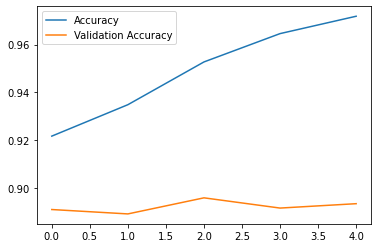

<Figure size 432x288 with 0 Axes>

In [20]:
#plot the accuracy of the model on the training set and test set
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

While the fitting does better on the training data over time (which is what a neural net is designed to do over each epoch), the validation accuracy does not budge at all. Thus, the more epochs we impose on the neural net, the more we risk over-fitting on the training data.

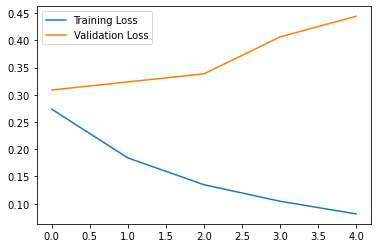

<Figure size 432x288 with 0 Axes>

In [21]:
#plot the losses of the training data and testing data
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")

Now we want to execute our model on some test reviews.

In [22]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=50)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

    
test_sentence1 = "The film's breadth of opinions - of which there are too many to recount in a single article - indicates that there is no 'right' choice, and impressively captures a debate that may not rage forever."
predict_sentiment(test_sentence1)
test_sentence2 = "The documentary would have been that much better with a more explicit focus on why the average filmgoer should care."
predict_sentiment(test_sentence2)

Predicted label:  0
Predicted label:  1
